# Machine Learning Project: Wine Quality
### David García Allo - 26/02/2022 
### Latest update: 14/07/2022
#### Description
Train a Decision Tree Regressor to predict the wine quality from the data obtained in the given url. Visualize the data to know $\\$
the info contained, in form of a pandas DataFrame and in form of histograms to visualize the typical values of each property. $\\$
Study the deviations from the predictions to the real labels and the possibility of using a set of models to improve the precision.
#### External modules needed
- numpy
- pandas
- matplotlib
- sklearn

#### Comments
We can achieve better precision predicting the wine quality using a set of models (Decision Trees) using Gradient Boosting $\\$
instead of only use one Decision Tree. We are capable of reduce the mean squared error from ~0,45 to ~0,35 with 50 models.

### Import needed modules and functions

In [1]:
import urllib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor

### Loading and preparing the data

In [2]:
#Loading data
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
wine_data  = urllib.request.urlopen(target_url)

#Creating the lists and filling the data
data, labels, col_names = [], [], []
firstLine = True
for line in wine_data:
    if firstLine:
        col_names = [name.strip()[1:-1] for name in line.decode("utf-8").strip().split(";")] #First line is for the name of the columns
        firstLine = False
    else:
        row_values = line.decode("utf-8").strip().split(";") #split on semi-colon
        labels.append(float(row_values[-1])) #put labels in separate array
        row_values.pop() #remove label from row
        row_values = [float(value) for value in row_values] #convert row to floats
        data.append(row_values)
rows = len(data)
cols = len(data[0])

### Visualize the data

In [3]:
labels_col = np.array(labels).reshape(len(labels),1) #REshape into column to visualize with the data
panda = pd.DataFrame(np.concatenate((data, labels_col), axis=1), columns = col_names)
panda

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0


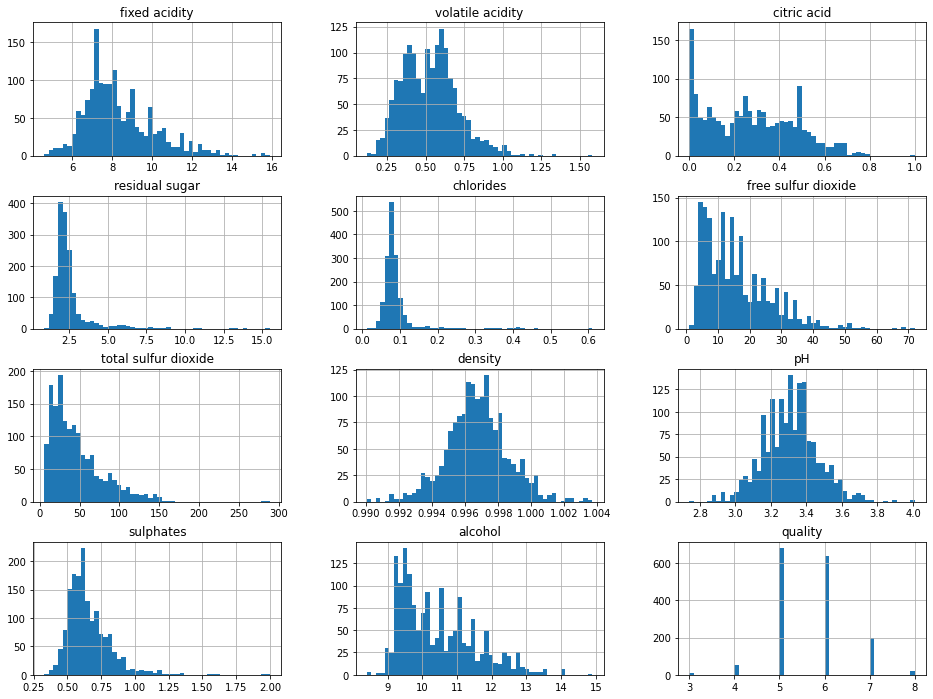

In [4]:
#Graphical visualization of the data
panda.hist(bins=50, figsize=(16,12))
plt.show()

### Split Train Test samples

In [5]:
#Selecting random index in the dataset
nSample = int(rows * 0.30) #take fixed test set 30% of sample
indexTest = random.sample(range(rows), nSample) 
indexTest.sort()
indexTrain = [i for i in range(rows) if not(i in indexTest)]
#Define test and training attribute and label sets from the random indexs obtained
dataTrain  = [data[i] for i in indexTrain]
dataTest   = [data[i] for i in indexTest]
labelTrain = [labels[i] for i in indexTrain]
labelTest  = [labels[i] for i in indexTest]
#We could use sklearn.model_selection.train_test_split instead

### Train a Decision Tree Regressor and obtain the mean squared error (mse) of the quality predictions

In [6]:
#We could do a GridSearch if we need the best hyperparameters
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(dataTrain,labelTrain)
preds = tree.predict(dataTest)
mse = sum([(labelTest[i]-preds[i])**2 for i in range(len(preds))])/len(preds)
print('Mean Squared Error of %.4f in the wine quality prediction'%mse)

Mean Squared Error of 0.4461 in the wine quality prediction


### Train a set of Decision Tree Regressors using Gradient Boosting

In [7]:
nTrees       = 50  # number of trees
max_depth    = 3   # hyperparameter of the trees
learn_rate   = 0.1 # learning rate to update the residuals

models = [DecisionTreeRegressor(max_depth=max_depth, random_state=42)]*nTrees  # we have 50 trees with the same parameters
models_preds = [] # list to hold models predictions

residuals = labelTrain # initializing residuals as labelTrain for the first model

for model in models: # loop to fit, make predictions and save residuals for a new model
    model.fit(dataTrain, residuals)  # train the actual model with the latest residuals residuals
    trainPred = model.predict(dataTrain) # predict on train sample to compute new residuals

    #use new predictions to update residuals
    residuals = [residuals[i] - learn_rate * trainPred[i] for i in range(len(residuals))]

    # make prediction on the test sample and add to the predictions list
    testPred = model.predict(dataTest)
    models_preds.append(list(testPred))

## Build cumulative prediction from first "n" models

In [8]:
mse_list = []  # list to hold mean squared errors and observe the progress as we increase number of models
pred_list = [] # list of lists with the predictions

for index_model in range(len(models)):
    prediction = []                # prediction for the "i_model" that will append to "pred_list"
    
    for i in range(len(labelTest)):    # going through the test sample
        prediction.append(sum([models_preds[j][i] for j in range(index_model + 1)]) * learn_rate)
        
    pred_list.append(prediction)
    
    errors = [(labelTest[j] - prediction[j]) for j in range(len(labelTest))] # errors on each event of the test sample
    mse_list.append(sum([error**2 for error in errors]) / len(labelTest))    # mse of the test sample

## Plot the mse evolution vs the number of models

We obtain that the mean squared error decreases when we increase the number of models
Minimum MeanSquaredError with 50 models is: 0.3562


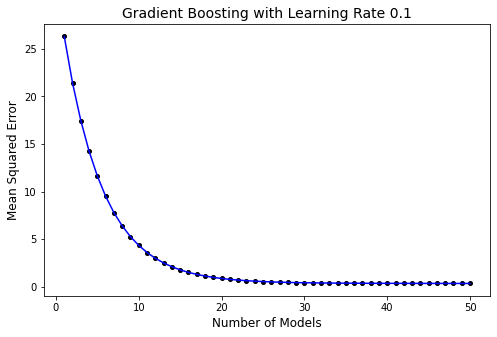

In [9]:
models_number = [i + 1 for i in range(len(models))] # x-axis for the plot

plt.figure(figsize=(8,5))
plt.plot(models_number,mse_list,'k.',markersize=8)
plt.plot(models_number,mse_list,'b-')
plt.xlabel('Number of Models', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.title('Gradient Boosting with Learning Rate '+ str(learn_rate), fontsize=14)


print('We obtain that the mean squared error decreases when we increase the number of models')
print('Minimum MeanSquaredError with %i models is: %.4f'%(nTrees,min(mse_list)))
plt.show()